In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import doctest # To test the code with the examples in the docstring of the functions
import os
from PIL import Image
import tensorflow as tf

# II.B. Eigenface Method

In [2]:
def averageFace(Q : np.ndarray) -> np.ndarray :
    """
    Compute the average face of a set of images (sketches or photos)

    Parameters
    ----------
    Q : np.array
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.

    Returns
    -------
    np.array
        A 2D numpy array of shape (n, 1) containing the average face.
    """
    return np.mean(Q, axis=1).reshape(-1,1)

def eigenfaces(Q : np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray] :
    """
    Implementation of the eigenfaces algorithm

    Parameters
    ----------
    Q : np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (n, m) containing the eigenfaces
    np.ndarray
        A 2D numpy array of shape (n, m) containing the eigenvectors
    np.ndarray
        A 2D numpy array of shape (m, m) containing the matrix of eigenvalues after transformations

    >>> eigenfaces(np.array([[2,0],[0,5]]))[0].shape
    (2, 2)

    """
    # Compute the mean of the columns of Q (mean image)
    mp = averageFace(Q)
    # Subtract the mean from each column of Q
    Ap = Q - mp
    # Compute eigenvector matrix and eigenvalues of Atp*Ap
    eigvals, Vp = np.linalg.eig(np.matmul(Ap.transpose(),Ap))



    # # Remove the negative eigenvalues for the sqrt
    # Vp = np.delete(Vp, eigvals < 0, axis=1)
    # eigvals = np.delete(eigvals, eigvals < 0)



    # Compute the orthormal eigenvector matrix of the covariance matrix
    eigPower = np.linalg.inv(sp.linalg.sqrtm(np.diag(eigvals)))
    Up = np.matmul(np.matmul(Ap,Vp),eigPower)

    return Up, Vp, eigPower

def featuresEigenfaces(Up : np.ndarray, P : np.ndarray) -> np.ndarray :
    """
    Implementation of the featuresEigenfaces algorithm.

    Parameters
    ----------
    Up : np.ndarray
        A 2D numpy array of shape (n, m) containing the eigenfaces.
    P : np.ndarray
        A 2D numpy array of shape (n, k) where n is the number of pixels in each image and k is the number of images.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (m, k) containing the features of the images.
    """
    return np.matmul(Up.transpose(),P)

In [3]:
# use doctest to test the functions
doctest.testmod(verbose=True)

Trying:
    eigenfaces(np.array([[2,0],[0,5]]))[0].shape
Expecting:
    (2, 2)
ok
3 items had no tests:
    __main__
    __main__.averageFace
    __main__.featuresEigenfaces
1 items passed all tests:
   1 tests in __main__.eigenfaces
1 tests in 4 items.
1 passed and 0 failed.
Test passed.


TestResults(failed=0, attempted=1)

In [4]:
def getData(path : str) -> tuple[np.ndarray, list[str]]:
    """
    Reads the images data in the given path and returns it as a numpy array (each column represent an image)

    Parameterscould not find all required packages: libalpm.so >=14
    ----------
    path : str
        The path to the directory containing the images data.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.
    list
        A list containing the filenames of the images.
    """
    # Initialize the array of images
    dir = os.listdir(path)
    #TODO: Check
    dir.sort()
    img = Image.open(path + dir[0])
    # if image has 3 channels, convert it to grayscale
    img = img.convert('L') if len(np.array(img).shape) == 3 else img

    nbPixels = np.array(img).flatten().shape

    images = np.empty((nbPixels[0],len(dir)))

    filenames: list[str] = []
    for i,filename in enumerate(dir):
        img = Image.open(path + filename)
        # if image has 3 channels, convert it to grayscale
        img = img.convert('L') if len(np.array(img).shape) == 3 else img
        images[:,i] = np.array(img).flatten().transpose()

        filenames.append(filename)

    return images, filenames

def plotResults(inputRGB : np.ndarray,inputGrayscale : np.ndarray, pseudoSketch : np.ndarray, imageName : str, sketchPath : str):
    """
    Create a plot of three subplots to show the results

    Parameters
    ----------
    inputRGB : np.ndarray
        A 3D numpy array of shape (n, m, 3) containing the input RGB image.
    inputGrayscale : np.ndarray
        A 2D numpy array of shape (n*m) containing the input grayscale image.
    pseudoSketch : np.ndarray
        A 2D numpy array of shape (n*m) containing the pseudo-sketch image.

    Returns
    -------
    None
    """
    size = inputRGB.shape[0:2]

    fig, ax = plt.subplots(2,2)
    ax[0,0].imshow(inputRGB)
    ax[0,0].set_title('Original Image')
    ax[0,0].axis('off')

    ax[0,1].imshow(inputGrayscale.reshape(size),cmap='gray')
    ax[0,1].set_title('Grayscale Image')
    ax[0,1].axis('off')

    ax[1,0].imshow(pseudoSketch.reshape(size),cmap='gray')
    ax[1,0].set_title('Pseudo-sketch Image')
    ax[1,0].axis('off')

    ax[1,1].imshow(np.array(Image.open(sketchPath + imageName[:-4] + "-sz1.jpg")),cmap='gray')
    ax[1,1].set_title('Real sketch Image')
    ax[1,1].axis('off')

    plt.show()

In [5]:

# TODO: Check
images, photoNames = getData("./data/photos/")

# # TODO: Remove
# plt.imshow(averageFace(images).reshape(250,200),cmap='gray')
# eigenfacesMatrix, _, eip = eigenfaces(images)
# features = featuresEigenfaces(eigenfacesMatrix, images)

# III.A. Photo-to-Sketch Transformation

> In this section, we reimplement the III.A part of the article, following the 6 steps described

M1-005-01.jpg


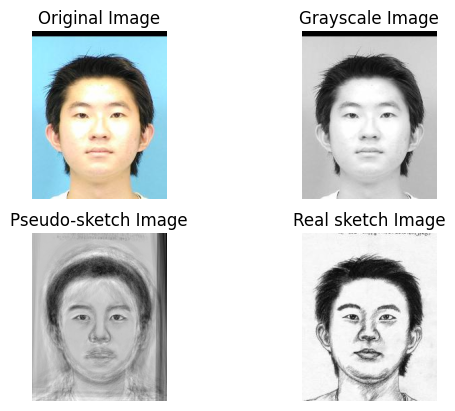

In [6]:
# TODO: Check
photoPath = "./data/photos/"
sketchPath = "./data/sketches/"

# Get the data then split into training and testing sets for the photos
photoSet, photoNames = getData(photoPath)
sketchSet, SketchNames = getData(sketchPath)

# Split the data into training and testing sets using 80% of the data for training or using the same training set as the AI model used later
delimTrain = int(photoSet.shape[1]*0.8) # 80% of the data for training

phototrainingSet = photoSet[:,:delimTrain]
phototestingSet = photoSet[:,delimTrain:]

sketchtrainingSet = sketchSet[:,:delimTrain]
sketchtestingSet = sketchSet[:,delimTrain:]

# Get the input image and its name
numImage = delimTrain + 1

inputImage = phototestingSet[:,1].reshape(-1,1)
imageName = photoNames[numImage]
inputRGB = np.array(Image.open(photoPath + imageName))
print(imageName)

def pseudoSketchTransfo(phototrainingSet : np.ndarray, sketchtrainingSet : np.ndarray, inputImages : np.ndarray) -> np.ndarray:
    """
    Implementation of the pseudoSketchTransfo algorithm.

    Parameters
    ----------
    phototrainingSet : np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.
    sketchtrainingSet : np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.
    inputImage : np.ndarray
        A 2D numpy array of shape (n, d) containing the input images, where d is the number of images.

    Returns
    -------
    np.array
        A 2D numpy array of shape (n, d) containing the pseudo-sketch images for each input image.
    """

    # Step 1
    mp = averageFace(phototrainingSet)
    ms = averageFace(sketchtrainingSet)

    # Step 2
    Ap = phototrainingSet - mp
    Up, Vp, eigPower = eigenfaces(Ap)

    # Step 3 adapted to multiple input images
    Pk = inputImages - mp

    # Step 4 adapted to multiple input images
    bp = featuresEigenfaces(Up, Pk)

    # Step 5 : Reconstruction of the pseudo-sketch
    As = sketchtrainingSet - ms
    Sr = As @ Vp @ eigPower @ bp

    # Step 6
    Tr = Sr + ms

    # Get the real part of the image and plot the results
    return Tr.real

pseudoSketch = pseudoSketchTransfo(phototrainingSet, sketchtrainingSet, inputImage)
plotResults(inputRGB, inputImage, pseudoSketch,imageName, sketchPath)

### Application à plusieurs images en une seule fois (utile pour les parties suivantes)

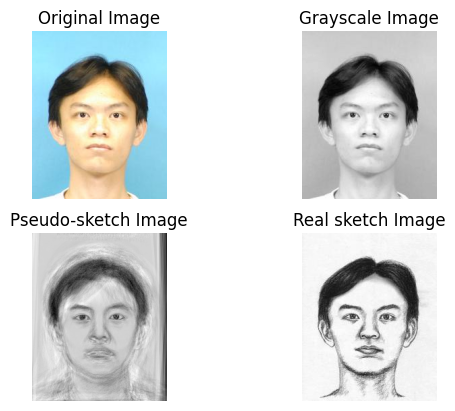

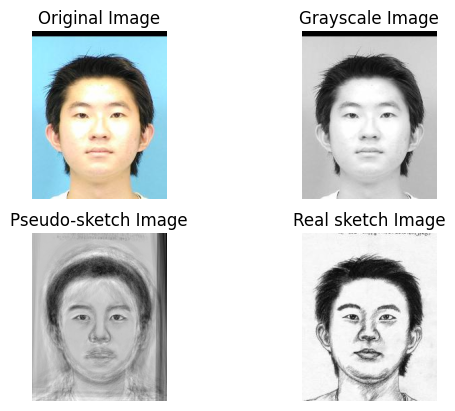

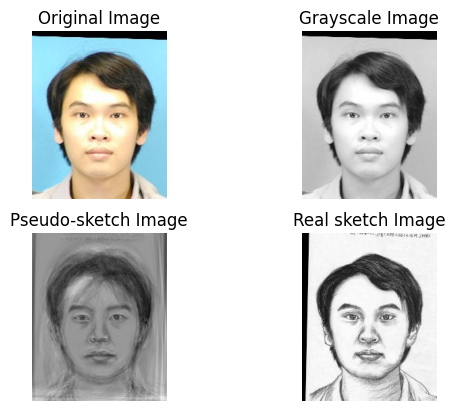

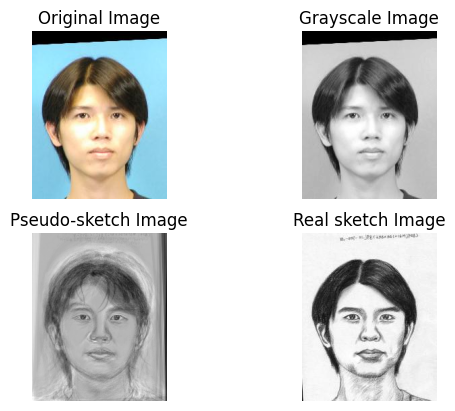

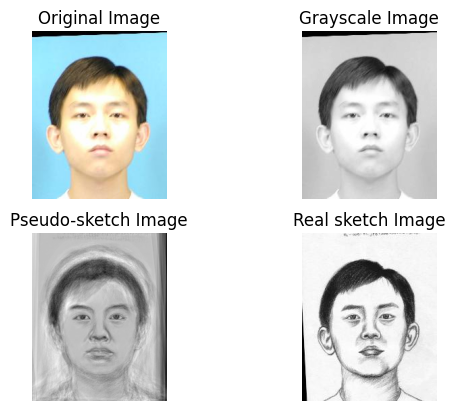

In [7]:
inputImages = phototestingSet[:,0:5]
imageNames = []
inputsRGB = []
for i in range(5):
    imageName = photoNames[delimTrain + i]
    inputRGB = np.array(Image.open(photoPath + imageName))

pseudoSketchs = pseudoSketchTransfo(phototrainingSet, sketchtrainingSet, inputImages)
for i in range(5):
    imageName = photoNames[delimTrain + i]
    inputRGB = np.array(Image.open(photoPath + imageName))
    plotResults(inputRGB, inputImages[:,i], pseudoSketchs[:,i], imageName, sketchPath)

# III.B. Sketch Recognition

In [8]:
def getPhotoSetsAI(imageNames : list[str], imageSet : np.ndarray) -> tuple[np.ndarray, list[str], np.ndarray, list[str]] :
    """

    Args
    ----
    imageNames : list
        A list containing the filenames of the images.
    imageSet : np.ndarray
        A 2D numpy array of shape (n, m) where n is the number of pixels in each image and m is the number of images.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (n, m) containing the training set of the photos.
    list
        A list containing the filenames of the training set of the photos.
    np.ndarray
        A 2D numpy array of shape (n, m) containing the testing set of the photos.
    list
        A list containing the filenames of the testing set of the photos.
    """

    with open('test_names.txt') as f:
        testNames = f.readlines()
    with open('train_names.txt') as f:
        trainNames = f.readlines()
    indexTest = [imageNames.index(name[:-1]) for name in testNames]
    indexTrain = [imageNames.index(name[:-1]) for name in trainNames]
    
    return imageSet[:,indexTrain], [imageNames[i] for i in indexTrain], imageSet[:,indexTest], [imageNames[i] for i in indexTest]

In [9]:
# Choose between the AI implementation and the article implementation
ARTICLE_IMPLEMENTATION = False

In [10]:
photoPath = "./data/photos/"
sketchPath = "./data/sketches/"

# Get the data then split into training and testing sets for the photos
photoSet, photoNames = getData(photoPath)
sketchSet, SketchNames = getData(sketchPath)

if ARTICLE_IMPLEMENTATION:
    delimTrain = int(photoSet.shape[1]*0.8) # 80% of the data for training

    phototrainingSet = photoSet[:,:delimTrain]
    phototestingSet = photoSet[:,delimTrain:]

    sketchtrainingSet = sketchSet[:,:delimTrain]
    sketchtestingSet = sketchSet[:,delimTrain:]

else :
    phototrainingSet, photoTrainNames, phototestingSet, photoTestNames  = getPhotoSetsAI(photoNames, photoSet)
    sketchtrainingSet, sketchTrainNames, sketchtestingSet, sketchTestNames = getPhotoSetsAI(SketchNames, sketchSet)

ValueError: 'M-055-01.jpg' is not in list

In [ ]:
# Step 1 : Photo eigenspace
mp = averageFace(phototrainingSet)
Ap = phototrainingSet - mp
Up, Vp, eigPowerP = eigenfaces(Ap)

# Step 2 : Sketch eigenspace
ms = averageFace(sketchtrainingSet)
As = sketchtrainingSet - ms
Us, Vs, eigPowerS = eigenfaces(As)


### Étape 3 : deux cas possibles en fonction de si utilisation d'IA ou de l'implémentation directe de l'article

> Reprise des fonctions nécessaires du fichier Pix2Pix.ipynb dans lequel a été entrainé le modèle

In [ ]:
def resize(image, height, width):
  """ 
  Origine de la fonction : Pix2Pix
  Pour redimensionner les images à la taille souhaitée
  """
  image = tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return image

def denormalize(image):
  image = (image+1)
  image = image*127.5
  return image

def normalize(image):
  image = (image/ 127.5) - 1
  return image

def load(image_path):
    """ Lecture à l'aide de tensorflow des images"""
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image,channels=3)
    image = tf.cast(image, tf.float32)
    return image

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

# Step 3 : Pseudo-sketch transformation for each photo of the testing set
if ARTICLE_IMPLEMENTATION :
    SrAll = pseudoSketchTransfo(phototrainingSet, sketchtrainingSet, phototestingSet)
else :

    model = tf.keras.models.load_model('./PortraitToSketch.keras')
    size = np.array(Image.open(photoPath + photoTestNames[0])).shape[0:2]
    SrAll = np.zeros((size[0]*size[1], phototestingSet.shape[1]))

    for i, filename in enumerate(photoTestNames):
        image = normalize(resize(load(photoPath + filename),256,256)) # Récupération de l'image et normalisation pour le modèle
        image = tf.convert_to_tensor(image)

        modelOutput = model.predict(image[tf.newaxis, ...])[0]

        modelOutput = tf.cast(denormalize(modelOutput), tf.int32)
        modelOutput = tf.clip_by_value(modelOutput,0,255)

        pseudoSketch = rgb2gray(resize(modelOutput[tf.newaxis, ...], size[0], size[1])[0]) # Obtention du pseudo-sketch de la bonne taille et en noir et blanc

        SrAll[:,i] = np.array(pseudoSketch).flatten()


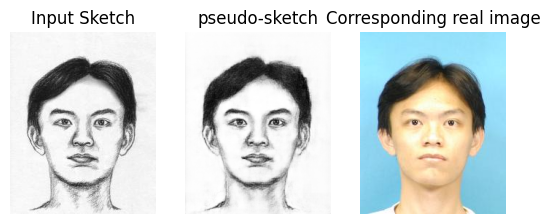

In [146]:
# Step 4 : Compute the eigensketch weight vector for each pseudo-sketch
br = featuresEigenfaces(Us, SrAll)

# Step 5 : same thing but with the testing sketch (here, the first of the testing set)
bs = featuresEigenfaces(Us, sketchtestingSet[:,0].reshape(-1,1))

# Step 6 : Compute the distances
## We first need each vector of reconstruction coefficients cp (and cs)
cs = Vs @ eigPowerS @ bs
cp = Vp @ eigPowerP @ br

# bp is the vector of reconstruction coefficients of the pseudo-sketch
bp = np.linalg.inv(eigPowerP) @ Vp.T @ cs
## Using d1 = ||cp - cs||, we search for the minimum distance
d1: np.ndarray = np.linalg.norm(cp - cs, axis=0)
d2: np.ndarray = np.linalg.norm(br - bs, axis=0)
d3: np.ndarray = np.linalg.norm(br - bp, axis=0)

min_d1 = np.argsort(d1)
min_d2 = np.argsort(d2)
min_d3 = np.argsort(d3)
## Get the real sketch and plot the results
minIndex = min_d2[0]
inputSketch = sketchtestingSet[:,0]
sketchName = SketchNames[delimTrain]
pseudoSketchFound = SrAll[:,minIndex]
imageName = photoNames[delimTrain + minIndex]
imageResult = np.array(Image.open(photoPath + imageName))

size = imageResult.shape[0:2]
fig, ax = plt.subplots(1,3)
ax[0].imshow(inputSketch.reshape(size), cmap='gray')
ax[0].set_title('Input Sketch')
ax[0].axis('off')
ax[1].imshow(pseudoSketchFound.reshape(size),cmap='gray')
ax[1].set_title('pseudo-sketch')
ax[1].axis('off')
ax[2].imshow(imageResult,cmap='gray')
ax[2].set_title('Corresponding real image')
ax[2].axis('off')

plt.show()